- https://qiita.com/sasayabaku/items/b7872a3b8acc7d6261bf

# 後ろ長フレームの予測誤差を取れるようにする

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def sin(x, T=100):
    return np.sin(2.0 * np.pi * x / T)

# sin波にノイズを付与する
def toy_problem(T=100, ampl=0.05):
    x = np.arange(0, 2 * T + 1)
    noise = ampl * np.random.uniform(low=-1.0, high=1.0, size=len(x))
    return sin(x) + noise

f = toy_problem()
print(f.shape)
plt.figure(figsize=(6,2));plt.plot(f);plt.show()

(201,)


<Figure size 600x200 with 1 Axes>

In [2]:
def make_dataset(low_data, n_prev=100):

    data, target = [], []
    maxlen = 25

    for i in range(len(low_data)-maxlen):
#     for i in range(len(low_data)-maxlen-maxlen):
        data.append(low_data[i:i + maxlen]) # x (25フレーム切り取ってくる)
#         target.append(low_data[i+maxlen:i +maxlen+maxlen]) # y (xの1フレーム先~25フレーム先)
        target.append(low_data[i+maxlen]) # y (xの1フレーム先~25フレーム先)

    re_data = np.array(data).reshape(len(data), maxlen, 1)
    re_target = np.array(target).reshape(len(data), 1)

    return re_data, re_target


#g -> 学習データ，h -> 学習ラベル
g, h = make_dataset(f)
print(g.shape, h.shape)

(176, 25, 1) (176, 1)


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

# TODO: LSTMCell使う
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, inputs, hidden=None):
        output, (hidden, cell) = self.lstm(inputs, hidden) # 10x25x8,1x25x8,1x25x8
        output = self.fc(output[:, -1, :]) # 10x25x8 -> 10x1x8 -> 10x1
        return output #, hidden, cell

In [4]:
class SinDataset(Dataset):
    def __init__(self):
        X, Y = make_dataset(f)
        self.X = np.array(X, np.float32)
        self.Y = np.array(Y, np.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [5]:
# model = Model(1, 8, 1)
# data_loader = DataLoader(SinDataset(), batch_size=10, shuffle=True)
# x,_ = iter(data_loader).next()
# print(x.shape)
# output, hidden, cell = model(x)
# output.shape, hidden.shape, cell.shape

In [6]:
model = Model(1, 8, 1)
data_loader = DataLoader(SinDataset(), batch_size=10, shuffle=True)
x,_ = iter(data_loader).next()
print(x.shape)
output = model(x)
print(output.shape)

torch.Size([10, 25, 1])
torch.Size([10, 1])


In [7]:
model = Model(1, 8, 1)

loss_fn = F.mse_loss
optim = Adam(model.parameters())

data_loader = DataLoader(SinDataset(), batch_size=8, shuffle=True)

from tqdm import tqdm
from collections import OrderedDict

with tqdm(range(100), desc="Train", ncols=10) as _tqdm:
    for epoch in _tqdm:
        
        train_loss = 0.
        train_acc = 0.
        
        for x_batch, y_batch in data_loader:
            optim.zero_grad()
            output = model(x_batch)

            loss = loss_fn(output, y_batch)
            loss.backward()
            optim.step()

            train_loss += loss.item()
            train_acc += np.sum(np.abs((output.data - y_batch.data).numpy()) < 0.1)
        
        _tqdm.set_postfix(OrderedDict(
            ep=epoch+1, 
            loss="{:.2f}".format(train_loss), 
            acc="{:.2f}".format(train_acc)))

Train: 100%|█| 100/100 [00:14<00:00,  6.63it/s, ep=100, loss=0.03, acc=176.00]


torch.Size([176, 25, 1]) torch.Size([176, 1])


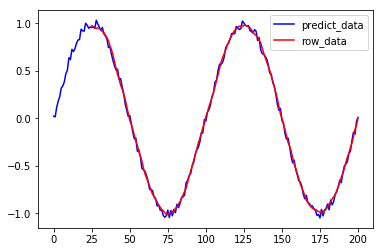

In [8]:
# 予測
g, h = make_dataset(f)
g = torch.from_numpy(np.array(g, np.float32))
pred = model(g) # (176, 25, 1) -> (176, 25, 1) # t+1のデータを予測したものが176個。
print(g.shape, pred.shape)
pred = pred.detach().numpy()

plt.figure()
plt.plot(range(0, len(f)), f, color="b", label="predict_data")
plt.plot(range(25,len(pred)+25),pred, color="r", label="row_data")
plt.legend()
plt.show()

入力として使った部分だけ青でプロット


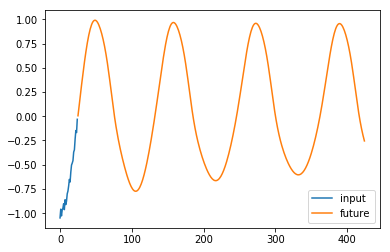

すべての学習用データを青でプロット


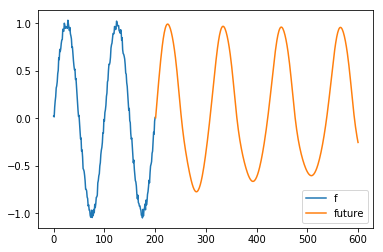

In [10]:
g, h = make_dataset(f) # (176, 25, 1) (176, 1)

# 一番最後のデータから400フレーム分予測して伸ばす。
future_test = g[-1].T # 1x25
row = future_test.reshape(-1)

# 未来の予測データを保存していく
future_result = []

# 未来予想
for step2 in range(400):

    test_data = np.reshape(future_test, (1, 25, 1)) # バッチ化
    test_data = torch.from_numpy(np.array(test_data, np.float32))
    
    batch_pred = model(test_data)[0,0] # 一番最後のフレームだけ使う
    batch_pred = batch_pred.detach().numpy() # スカラー
    
    future_test = np.delete(future_test, 0)
    future_test = np.append(future_test, batch_pred)
    
    future_result.append(batch_pred)


# sin波をプロット
print("入力として使った部分だけ青でプロット")
plt.figure()
plt.plot(range(0, len(row)), row, label="input")
plt.plot(range(len(row), len(row)+len(future_result)), future_result, label="future")
plt.legend()
plt.show()

# sin波をプロット
print("すべての学習用データを青でプロット")
plt.figure()
plt.plot(range(0, len(f)), f, label="f")
plt.plot(range(len(f), len(f)+len(future_result)), future_result, label="future")
plt.legend()
plt.show()